ML PROJECT

Importing libraries

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

getting data set

In [2]:
import pandas as pd
social_media=pd.read_csv('social-media.csv')

In [3]:
social_media.head()

,UserId,UsageDuraiton,Age,Country,TotalLikes
0,1,2,55,Turkey,5
1,2,6,45,Canada,10
2,3,3,50,Ireland,7
3,4,4,35,South Africa,5
4,5,1,58,Turkey,2


In [4]:
social_media.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserId         63 non-null     int64 
 1   UsageDuraiton  63 non-null     int64 
 2   Age            63 non-null     int64 
 3   Country        63 non-null     object
 4   TotalLikes     63 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 2.6+ KB


In [5]:
social_media["Country"].value_counts()

Country
Turkey          10
Germany          9
Panama           7
Australia        7
Canada           6
Bulgaria         6
Singapore        5
Serbia           3
South Africa     3
Ireland          2
Croatia          2
Kosovo           1
Barbados         1
Mexico           1
Name: count, dtype: int64

In [6]:
social_media.describe()

,UserId,UsageDuraiton,Age,TotalLikes
count,63.000000,63.000000,63.000000,63.000000
mean,31.761905,4.000000,33.777778,5.317460
std,18.015866,2.879292,15.540213,6.135106
min,1.000000,1.000000,18.000000,0.000000
25%,16.500000,2.000000,19.000000,1.500000
50%,32.000000,3.000000,26.000000,4.000000
75%,47.500000,5.000000,50.000000,6.000000
max,62.000000,13.000000,60.000000,28.000000


Saving figure Histogram_Plots


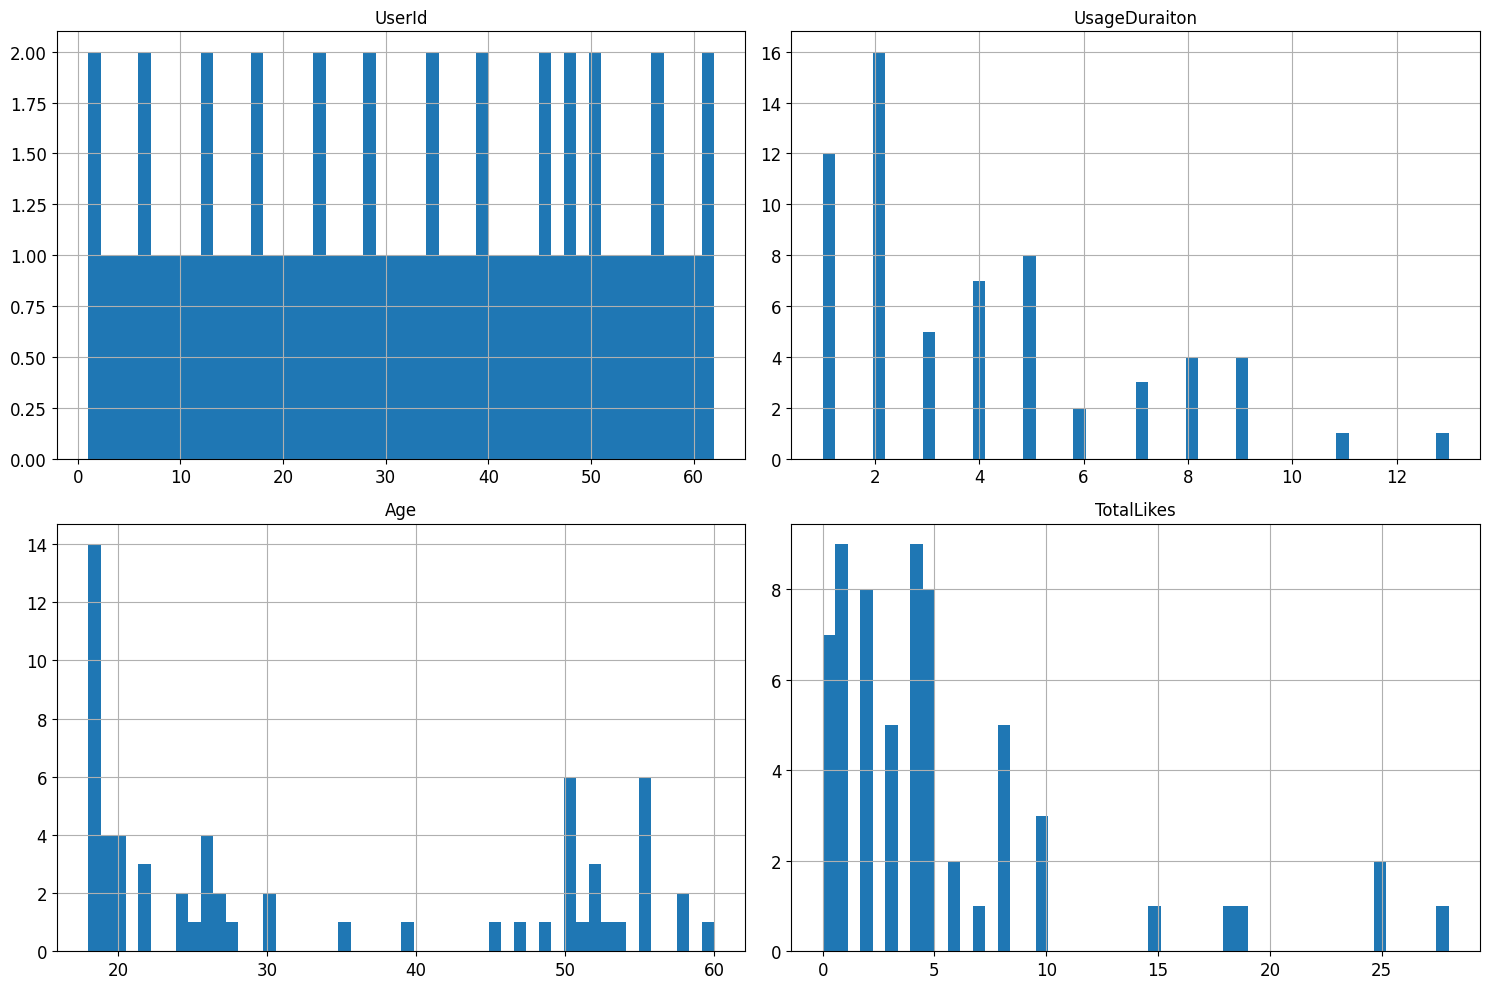

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
social_media.hist(bins=50, figsize=(15,10))
save_fig("Histogram_Plots")
plt.show()

Creating a test set

In [8]:
# to make this notebook's output identical at every run
np.random.seed(42)
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
train_set, test_set = split_train_test(social_media, 0.2)
print(len(train_set))
print(len(test_set))

51
12


In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [13]:
social_media_with_id = social_media.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(social_media_with_id, 0.2, "index")
social_media_with_id["id"] = social_media["UsageDuraiton"] * 1000 + social_media["Age"]
train_set, test_set = split_train_test_by_id(social_media_with_id, 0.2, "id")
test_set.head()

,index,UserId,UsageDuraiton,Age,Country,TotalLikes,id
0,0,1,2,55,Turkey,5,2055
2,2,3,3,50,Ireland,7,3050
6,6,7,3,50,Australia,1,3050
7,7,8,9,25,Canada,8,9025
8,8,9,8,27,Kosovo,10,8027


In [14]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(social_media, test_size=0.2, random_state=42)
test_set.head()

,UserId,UsageDuraiton,Age,Country,TotalLikes
61,61,9,18,Germany,18
57,57,2,55,Bulgaria,0
0,1,2,55,Turkey,5
43,44,2,18,Germany,2
5,6,13,18,Turkey,25


<Axes: >

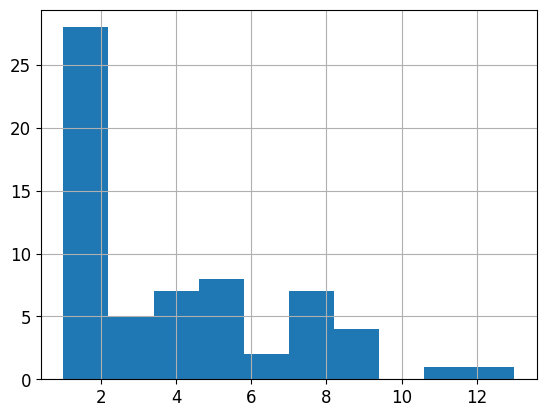

In [15]:
social_media["UsageDuraiton"].hist()

In [16]:
social_media["usage_cat"] = pd.cut(social_media["UsageDuraiton"],
                                   bins=[0, 2, 4, 6, 8, np.inf],
                                   labels=[1, 2, 3, 4, 5])
social_media["usage_cat"].value_counts()

usage_cat
1    28
2    12
3    10
4     7
5     6
Name: count, dtype: int64

<Axes: >

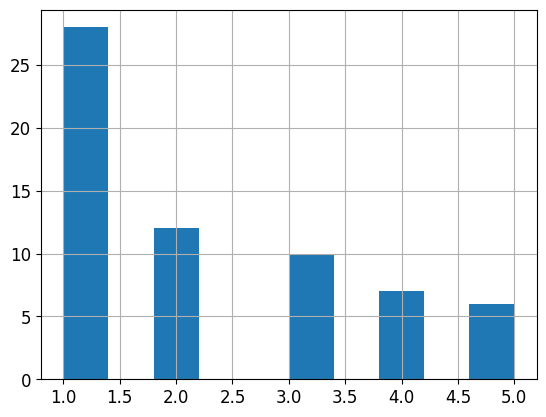

In [17]:
social_media["usage_cat"].hist()

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(social_media, social_media["usage_cat"]):
    strat_train_set = social_media.loc[train_index]
    strat_test_set = social_media.loc[test_index]
social_media["usage_cat"].value_counts() / len(social_media)

usage_cat
1    0.444444
2    0.190476
3    0.158730
4    0.111111
5    0.095238
Name: count, dtype: float64

In [21]:
def income_cat_proportions(data):
    return data["usage_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(social_media, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(social_media),  # Change here
    "Stratified": income_cat_proportions(strat_test_set),  # Change here
    "Random": income_cat_proportions(test_set),  # Change here
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props


,Overall,Stratified,Random,Rand. %error,Strat. %error
usage_cat,,,,,
1,0.444444,0.461538,0.538462,21.153846,3.846154
2,0.190476,0.230769,0.000000,-100.000000,21.153846
3,0.158730,0.153846,0.076923,-51.538462,-3.076923
4,0.111111,0.076923,0.153846,38.461538,-30.769231
5,0.095238,0.076923,0.230769,142.307692,-19.230769


Data Visualization

In [22]:
social_media = strat_train_set.copy()

Saving figure social_media_age_vs_total_likes


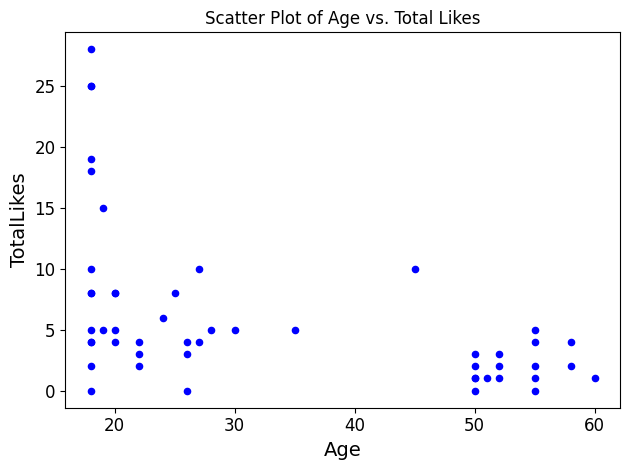

In [23]:
import matplotlib.pyplot as plt

# Create scatter plot for Age vs. Total Likes
social_media.plot(kind="scatter", x="Age", y="TotalLikes", color="blue")

# Save the plot as an image
plt.title("Scatter Plot of Age vs. Total Likes")
save_fig("social_media_age_vs_total_likes")

Saving figure better_visualization_plot


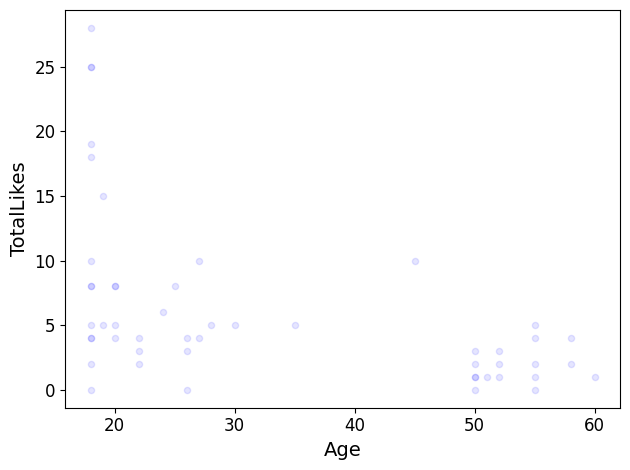

In [24]:
social_media.plot(kind="scatter", x="Age", y="TotalLikes", alpha=0.1,color="blue")
save_fig("better_visualization_plot")

Saving figure social_media_scatterplot


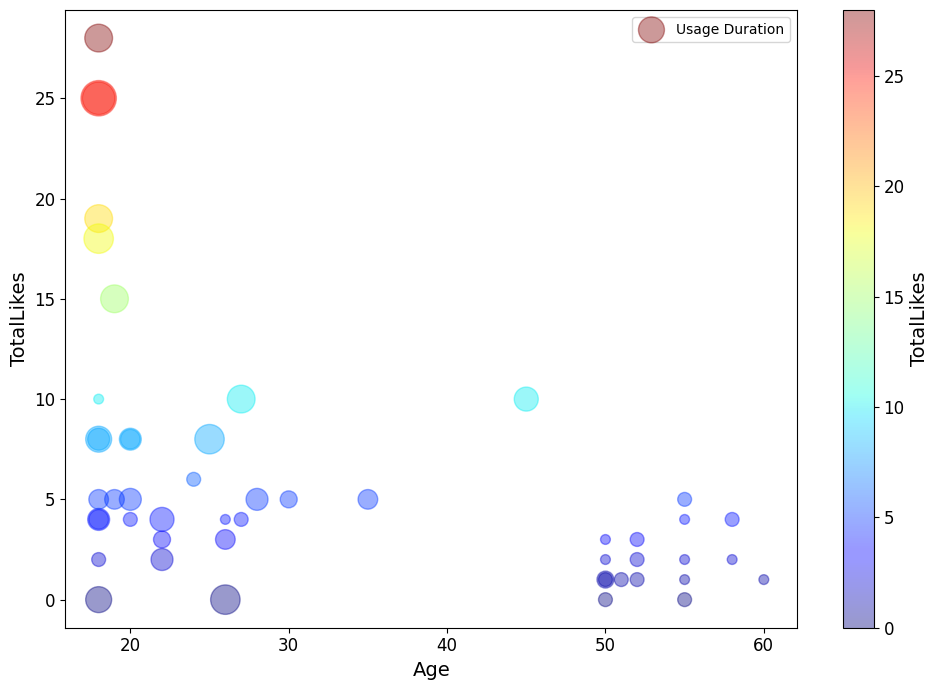

In [25]:
social_media.plot(kind="scatter", x="Age", y="TotalLikes", alpha=0.4,
             s=social_media["UsageDuraiton"]*50, label="Usage Duration", figsize=(10,7),
             c="TotalLikes", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

# Save the plot as an image
save_fig("social_media_scatterplot")

Saving figure social_media_total_likes_plot


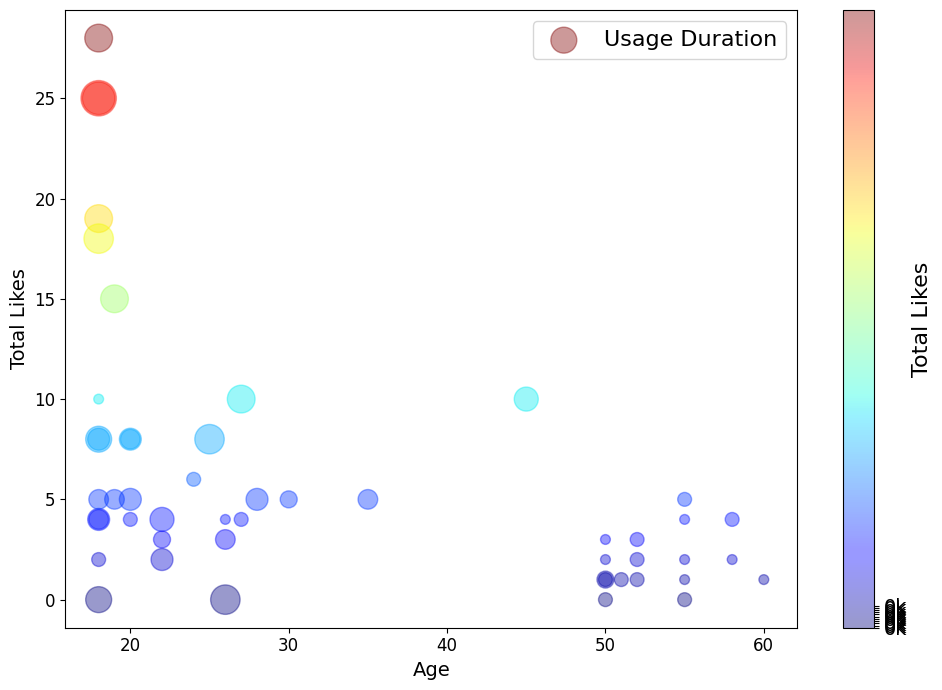

In [26]:
# Scatter plot with color based on TotalLikes
scatter = social_media.plot(kind="scatter", x="Age", y="TotalLikes", alpha=0.4,
                            s=social_media["UsageDuraiton"]*50, label="Usage Duration", figsize=(10,7),
                            c="TotalLikes", cmap=plt.get_cmap("jet"), colorbar=False, sharex=False)

# Setting labels
plt.ylabel("Total Likes", fontsize=14)
plt.xlabel("Age", fontsize=14)

# Create the color bar
likes = social_media["TotalLikes"]
tick_values = np.linspace(likes.min(), likes.max(), 11)
cbar = plt.colorbar(scatter.collections[0], ticks=tick_values/likes.max())
cbar.ax.set_yticklabels(["%dk" % (round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Total Likes', fontsize=16)

# Add legend
plt.legend(fontsize=16)

# Save the plot
save_fig("social_media_total_likes_plot")
plt.show()

Correlation

In [27]:
# Compute the correlation matrix, specifying numeric_only=True
corr_matrix = social_media.corr(numeric_only=True)

# Display correlations for TotalLikes
corr_matrix["TotalLikes"].sort_values(ascending=False)

TotalLikes       1.000000
UsageDuraiton    0.723375
UserId           0.017190
Age             -0.487657
Name: TotalLikes, dtype: float64

Saving figure scatter_matrix_social_media_plot


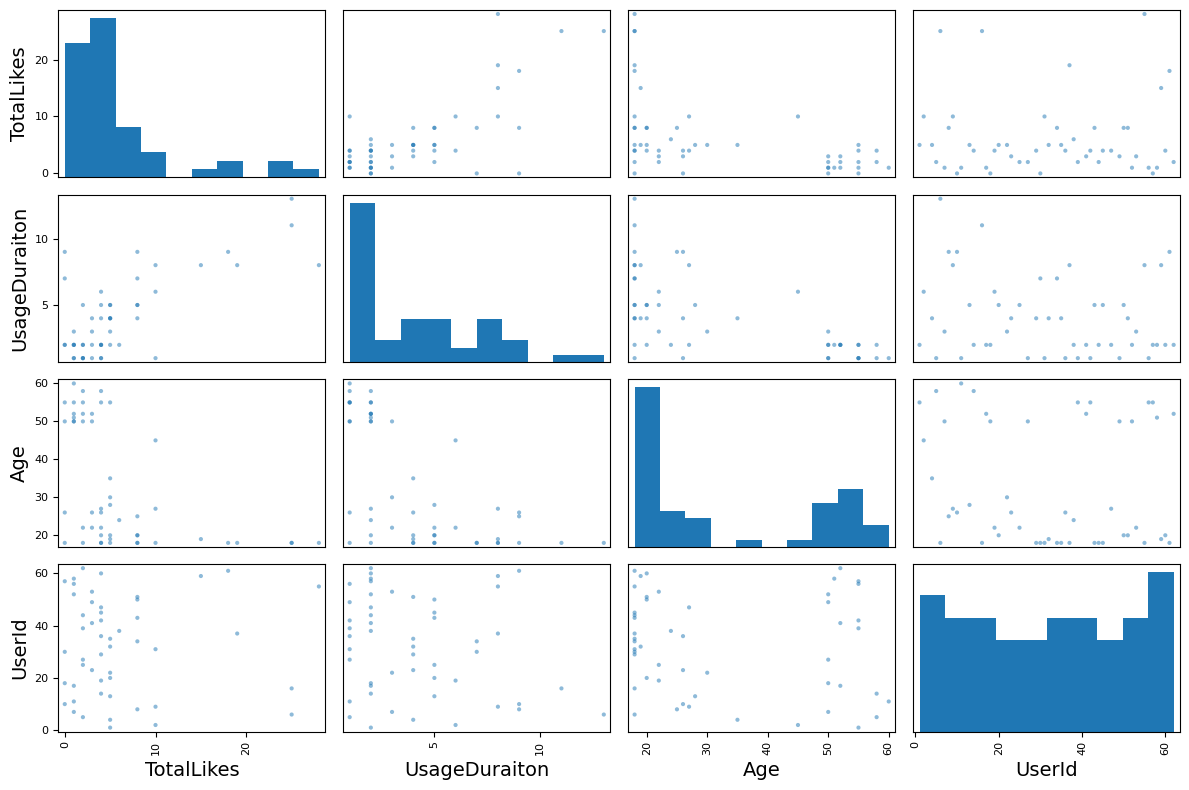

In [28]:
from pandas.plotting import scatter_matrix

attributes = ["TotalLikes", "UsageDuraiton", "Age", "UserId"]
scatter_matrix(social_media[attributes], figsize=(12, 8))

# Save the scatter matrix plot
save_fig("scatter_matrix_social_media_plot")
plt.show()

Saving figure age_vs_total_likes_scatterplot


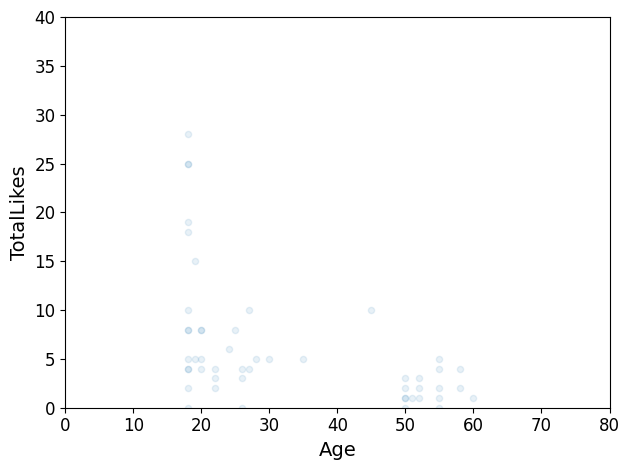

In [29]:

social_media.plot(kind="scatter", x="Age", y="TotalLikes",
             alpha=0.1)
plt.axis([0, 80, 0, 40])
save_fig("age_vs_total_likes_scatterplot")

Attribute combinations

In [30]:
social_media["likes_per_user"] = social_media["TotalLikes"] / social_media["UserId"]
social_media["duration_per_user"] = social_media["UsageDuraiton"] / social_media["UserId"]

# Compute correlation matrix
corr_matrix = social_media.corr(numeric_only=True)

# Sort the correlations by 'TotalLikes'
corr_matrix["TotalLikes"].sort_values(ascending=False)

TotalLikes           1.000000
UsageDuraiton        0.723375
likes_per_user       0.398443
duration_per_user    0.317269
UserId               0.017190
Age                 -0.487657
Name: TotalLikes, dtype: float64

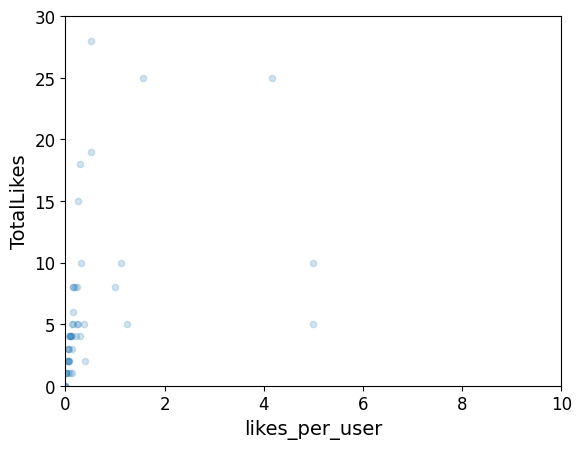

In [31]:
social_media.plot(kind="scatter", x="likes_per_user", y="TotalLikes", alpha=0.2)
plt.axis([0, 10, 0, 30])  # Adjust the range as per the dataset values
plt.show()

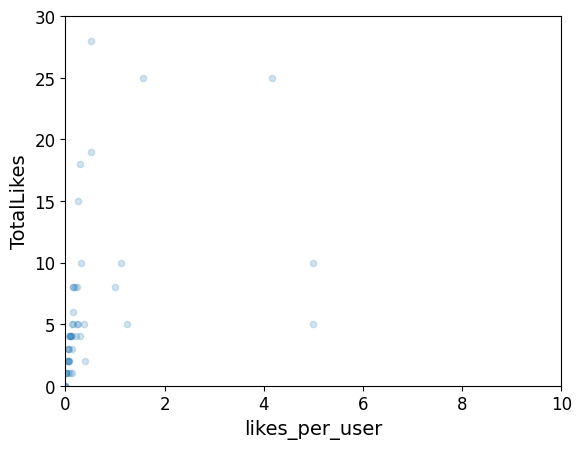

In [32]:
social_media.plot(kind="scatter", x="likes_per_user", y="TotalLikes", alpha=0.2)
plt.axis([0, 10, 0, 30])  # Adjust the range as per the dataset values
plt.show()

In [33]:
# Describe the dataset with the new features
social_media.describe()

,UserId,UsageDuraiton,Age,TotalLikes,likes_per_user,duration_per_user
count,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000
mean,32.060000,4.140000,32.90000,6.060000,0.509490,0.335827
std,18.682536,2.983013,15.74834,6.597495,1.127552,0.595724
min,1.000000,1.000000,18.00000,0.000000,0.000000,0.017857
25%,16.250000,2.000000,18.25000,2.000000,0.062585,0.043279
50%,33.000000,3.500000,26.00000,4.000000,0.142857,0.121324
75%,48.500000,5.750000,50.00000,8.000000,0.292740,0.229054
max,62.000000,13.000000,60.00000,28.000000,5.000000,3.000000


In [34]:
# Assuming 'UsageDuraiton' is the target label for prediction
social_media_features = strat_train_set.drop("UsageDuraiton", axis=1)  # drop the target column from features
social_media_labels = strat_train_set["UsageDuraiton"].copy()  # create a copy of the target column as labels

Prepare data for ml algorithm

In [43]:
X=train_set[['Age','TotalLikes']]
Y=train_set[['UsageDuraiton']]

Data Cleaning

In [44]:
social_media.isnull().any()

UserId               False
UsageDuraiton        False
Age                  False
Country              False
TotalLikes           False
usage_cat            False
likes_per_user       False
duration_per_user    False
dtype: bool

In [45]:
social_media.isnull().sum()

UserId               0
UsageDuraiton        0
Age                  0
Country              0
TotalLikes           0
usage_cat            0
likes_per_user       0
duration_per_user    0
dtype: int64

Handling text and categorial values

In [46]:
social_media_cat = social_media[["Country"]]
social_media_cat.head(10)

,Country
55,Australia
0,Turkey
36,Singapore
29,Bulgaria
40,Germany
61,Germany
26,Mexico
12,Serbia
15,Singapore
4,Turkey


Select and train model

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# Train the Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled,y_train)
predict_duration=lin_reg.predict(X_test_scaled)

Model evaluation

In [50]:
#Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

mae = mean_absolute_error(y_test,predict_duration)
mse = mean_squared_error(y_test,predict_duration)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,predict_duration)

print("Mean Absolute Error (MAE):",mae)
print("Mean Squared Error (MSE):",mse)
print("Root Mean Squared Error (RMSE):",rmse)
print("R-squared (R²):",r2)

Mean Absolute Error (MAE): 0.853629349129486
Mean Squared Error (MSE): 1.0771554500692218
Root Mean Squared Error (RMSE): 1.037860997469903
R-squared (R²): 0.8803160611034198


In [51]:
#coefficients of the model
print("\nCoefficients:",lin_reg.coef_)
print("Intercept:",lin_reg.intercept_)


Coefficients: [[-1.13509655  0.61681658]]
Intercept: [3.9]


Better evaluation using cross validation:

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np

neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
neg_mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

#cross-validation for R-squared
r2_scores = cross_val_score(lin_reg, X_train, y_train, scoring='r2', cv=5)
print(f"R-squared (R²) scores: {r2_scores}")
print(f"Mean R²: {r2_scores.mean()}\n")

#cross-validation for Mean Absolute Error (MAE)
neg_mae_scores = cross_val_score(lin_reg, X_train, y_train, scoring=neg_mae_scorer, cv=5)
mae_scores = -neg_mae_scores  # Convert negative MAE to positive values
print(f"MAE scores: {mae_scores}")
print(f"Mean MAE: {mae_scores.mean()}\n")

#cross-validation for Mean Squared Error (MSE)
neg_mse_scores = cross_val_score(lin_reg, X_train, y_train, scoring=neg_mse_scorer, cv=5)
mse_scores = -neg_mse_scores  # Convert negative MSE to positive values
print(f"MSE scores: {mse_scores}")
print(f"Mean MSE: {mse_scores.mean()}\n")

#RMSE from cross-validation MSE scores
rmse_scores = np.sqrt(mse_scores)
print(f"RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean()}")

R-squared (R²) scores: [ 0.09587664 -0.1470414   0.25865711  0.07042956  0.65633897]
Mean R²: 0.18685217477430238

MAE scores: [1.53225377 1.94445992 1.46117429 1.19452788 0.88082733]
Mean MAE: 1.4026486395646096

MSE scores: [3.55998575 7.45576909 4.44805732 1.84461635 1.54110494]
Mean MSE: 3.76990668954746

RMSE scores: [1.88679245 2.73052542 2.1090418  1.35816654 1.24141248]
Mean RMSE: 1.8651877385771094


Fine tuning

In [54]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'fit_intercept': [True, False],  
    'copy_X': [True, False],       
    'positive': [True, False]    
}

#GridSearchCV with 5-fold 
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

#Fit the GridSearchCV to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and model
best_param=grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best hyperparameters combination found: ", best_param)

Best hyperparameters combination found:  {'copy_X': True, 'fit_intercept': True, 'positive': False}


In [55]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predictions on the scaled test set
y_pred = best_model.predict(X_test_scaled)

#RMSE on the test set
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Test RMSE of the best model: {rmse}")

Test RMSE of the best model: 1.037860997469903


crossvalidation of best model

In [56]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation on the scaled training data
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)

# Calculate RMSE for each fold
cv_rmse = np.sqrt(-cv_scores)
print("Cross-validated RMSE scores for each fold: ", cv_rmse)
print("Average cross-validated RMSE: ", cv_rmse.mean())

Cross-validated RMSE scores for each fold:  [1.88679245 2.73052542 2.1090418  1.35816654 1.24141248]
Average cross-validated RMSE:  1.86518773857711


In [58]:
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
model_filename = 'best_linear_regression_model.pkl'
scaler_filename = 'data_scalar.pkl'

# Saving model using pickle
with open(model_filename, 'wb') as model_file:
    pickle.dump(best_model, model_file)
print(f"Best model saved as '{model_filename}'")

# Saving scaler using pickle
with open(scaler_filename, 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)
print(f"Scaler saved as '{scaler_filename}'")

Best model saved as 'best_linear_regression_model.pkl'
Scaler saved as 'data_scalar.pkl'
